# Predicting Kidney Transplants
### DATA1030 Fall 2022 Project
#### Lindsey Ross

## Loading in the data
**Source**: [Brazil Kidney Waitlist](https://www.kaggle.com/datasets/gustavomodelli/waitlist-kidney-brazil)

**About**: This dataset contains patient information for individuals registered on the waiting list of São Paulo State Organ Allocation System in Brazil between January 1, 2000 and December 29, 2017.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

df = pd.read_csv('../data/waitlist_kidney_brazil.csv', encoding='latin-1')

Many of the values in the dataset are written in Portugese, so they have to be translated to English:

In [3]:
df.replace(to_replace='Não', value='N', inplace=True)
df.replace(to_replace='Sim', value='Y', inplace=True)
df.replace(to_replace='Óbito Lista', value= 'DeathList', inplace=True)
df['age_cat'].replace(to_replace='18.a.60', value='From18to60', inplace=True)
df['age_cat'].replace(to_replace='Maior.60', value='Over60', inplace=True)
df['age_cat'].replace(to_replace='Menor.18', value='Below18', inplace=True)
df['cPRA_cat'].replace(to_replace='Entre_0_50', value='ZeroTo50', inplace=True)
df['cPRA_cat'].replace(to_replace='Entre_50_80', value='From50To80', inplace=True)
df['cPRA_cat'].replace(to_replace='Maior_80', value='Over80', inplace=True)
df.replace(to_replace='Outras', value='Other', inplace=True)
df.replace(to_replace='HAS', value='Hemolytic uremic syndrome (HUS)', inplace=True)
df.replace(to_replace='Diabetes', value='Diabetes', inplace=True)
df.replace(to_replace='GNC', value='Glumerulo-Nephrotic Syndrome (GNS)', inplace=True)
df.replace(to_replace='Pielonefrite', value='Pylonephritis (PN)', inplace=True)
df.replace(to_replace='heterozigoto', value='heterozygous', inplace=True)
df.replace(to_replace='homozigoto', value='homozygous', inplace=True)

df.rename(columns = {'anti.HBc':'HBc_antibodies', 'anti.HCV':'HCV_antibodies',
                    'underline_disease':'underlying_disease'}, inplace=True)

In [4]:
print(df['date_acutal'].value_counts())
print(df['priorization'].value_counts())
print(df['X36MthsTx'].value_counts())

43307    48153
Name: date_acutal, dtype: int64
N    48153
Name: priorization, dtype: int64
0    38276
1     9877
Name: X36MthsTx, dtype: int64


- Every value in date_acutal is 43307
- Every value in prioritization is N
- The X36MthsTx column is undocumented and redundant

These columns will be dropped. The Id column will also be dropped because it serves no meaning for the model.

In [5]:
df.drop(columns=['priorization'],inplace=True)
df.drop(columns=['date_acutal'],inplace=True)
df.drop(columns=['X36MthsTx'],inplace=True)
df.drop(columns=['Id'],inplace=True)

Investigating the similar features called 'Transplant' and 'Transplant_Y_N'

In [6]:
print(df['Transplant'].value_counts())
print(df['Transplant_Y_N'].value_counts())

N            25289
Y            13732
DeathList     9132
Name: Transplant, dtype: int64
N    34421
Y    13732
Name: Transplant_Y_N, dtype: int64


As we can see, Transplant_Y_N encompasses all of the information in the Transplant column and simplifies it into a simple classification problem with 2 classes: Yes or No. We will exclude the Transplant column because the 'DeathList' information is inconsistent with the number of deaths recorded elsewhere in the dataset. Transplant_Y_N will be the target variable for the classification problem, so the Transplant feaure will be dropped.

In [7]:
df.drop(columns=['Transplant'],inplace=True)

Investigating and cleaning the date feature.

In [8]:
print(df['date'].head())
df['date'] = pd.to_datetime(df['date'])
df['date'].info()

df['date_year'] = df['date'].dt.year
# print(df['date_year'].head(20))

df['date_month_num'] = df['date'].dt.month
# print(df['date_month_num'].head(20))

df['date_day'] = df['date'].dt.day
# print(df['date_day'].head(20))

df['date_dow'] = df['date'].dt.dayofweek
# print(df['date_dow'].head(20))

0    2017-06-29
1    2008-11-03
2    2010-07-13
3    2011-10-03
4    2006-07-05
Name: date, dtype: object
<class 'pandas.core.series.Series'>
RangeIndex: 48153 entries, 0 to 48152
Series name: date
Non-Null Count  Dtype         
--------------  -----         
48153 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 376.3 KB


Since we have turned the date feature into other, more useful features, we will drop the initial date feature.

In [9]:
df.drop(columns=['date'],inplace=True)

## EDA

In [10]:
print(df.dtypes)

age_at_list_registration        int64
age_cat                        object
time_on_Dialysis              float64
race                           object
sex                            object
underlying_disease             object
diabetes                        int64
Blood_type                     object
number_transfusion              int64
gestation                      object
number_gestation              float64
prior_transplant               object
number_prior_transplant         int64
subregion                      object
cPRA                            int64
cPRA_cat                       object
HLA_A1                          int64
HLA_A2                          int64
HLA_B1                          int64
HLA_B2                          int64
HLA_DR1                         int64
HLA_DR2                         int64
DR_00                          object
B_00                           object
A_00                           object
calculated_frequency_DR.f1    float64
calculated_f

In [11]:
print(df.shape)

(48153, 51)


In [12]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values for each feature:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values for each feature:
time_on_Dialysis    0.027745
number_gestation    0.595788
chagas              0.083318
HCV_antibodies      0.083318
agHBs               0.083318
razon_removed       0.682367
dtype: float64


The dataset has information regarding 50 features of 48153 patients on the kidney waitlist.

There are a few options for a ML question to ask for this dataset. 

If we are considering a regression problem, the target variable can the time that a person spends on the waitlist before receiving a kidney transplant. There are two different columns that represent this information: 'time' or 'Time_Tx'. The 'time' column is measured in days whereas the 'Time_Tx' column is measured in months, but otherwise these two columns show the exact same information.

In [13]:
# target variable can be time or Time_Tx

print(df['time'].describe())
print(df['Time_Tx'].describe())
print(df['Time_Tx'].value_counts())

count    48153.000000
mean      1090.576350
std        955.582713
min          0.000000
25%        414.000000
50%        800.000000
75%       1470.000000
max       6776.000000
Name: time, dtype: float64
count    48153.000000
mean        35.527375
std         30.977942
min          0.000000
25%         13.670000
50%         26.300000
75%         47.670000
max        225.870000
Name: Time_Tx, dtype: float64
12.17     1471
15.17      241
15.20      106
18.17      101
17.97       80
          ... 
216.53       1
80.70        1
158.80       1
158.23       1
129.47       1
Name: Time_Tx, Length: 4242, dtype: int64


The target variable is continuous. Below is a visualization of the distribution of the target variable.

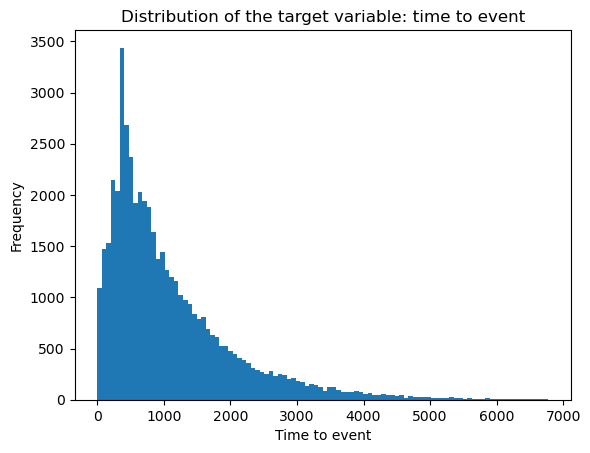

In [14]:
tv = 'time'
df[tv].plot.hist(bins=100)
plt.xlabel('Time to event')
plt.title('Distribution of the target variable: time to event')
plt.savefig('../figures/time_to_event_distribution.png')
plt.show()

Comparing the time to event (Time_Tx) and whether or not the patient received a transplant.

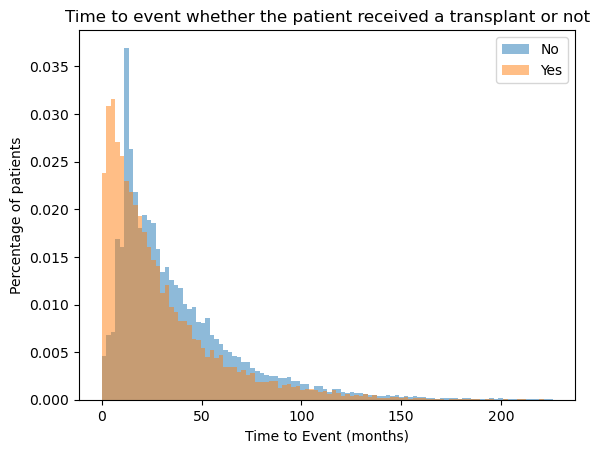

In [15]:
cats = df['Transplant_Y_N'].unique()
bin_range = (df['Time_Tx'].min(),df['Time_Tx'].max())

for c in cats:
    plt.hist(df[df['Transplant_Y_N']==c]['Time_Tx'],
             alpha=0.5,label=c,range=bin_range,
             bins=100,density=True)
plt.legend(['No', 'Yes'])
plt.ylabel('Percentage of patients')
plt.xlabel('Time to Event (months)')
plt.title('Time to event whether the patient received a transplant or not')
plt.savefig('../figures/time_to_event_transplant_y_n.png')
plt.show()

#### We can also consider a classification problem with this dataset
Research question: Can we develop a classification model that can predict whether a patient will receive a transplant or not?

Exploring the balance of the target variable:

N    34421
Y    13732
Name: Transplant_Y_N, dtype: int64
Percentage of patients who received a transplant or did not:
N    0.714826
Y    0.285174
Name: Transplant_Y_N, dtype: float64


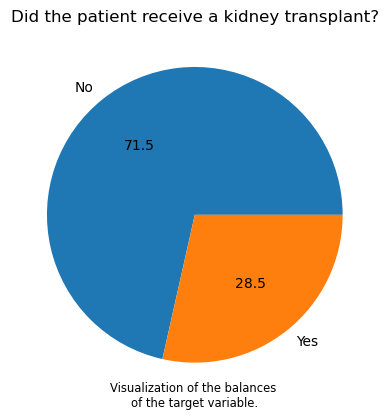

In [16]:
# Transplant_Y_N as the target variable
print(df['Transplant_Y_N'].value_counts())

print('Percentage of patients who received a transplant or did not:')
percent_transplants = df['Transplant_Y_N'].value_counts()/len(df)
print(percent_transplants)

caption = 'Visualization of the balances \n\
of the target variable.'

percent_transplants.plot.pie(labels=['No','Yes'],autopct='%.1f')
plt.title('Did the patient receive a kidney transplant?')
plt.ylabel('')
plt.savefig('../figures/pie_transplant_y_n.png')
plt.text(0,-1.3,caption,size='small',ha='center')
plt.show()

Now we will look at the age_at_list_registration and age_cat features.

Simple plots showing the distribution of patients by age. The first bar plot shows the count of patients in each age category. The second histogram shows the distribution of ages of people on the waiting list.

From18to60    34752
Over60        11775
Below18        1626
Name: age_cat, dtype: int64


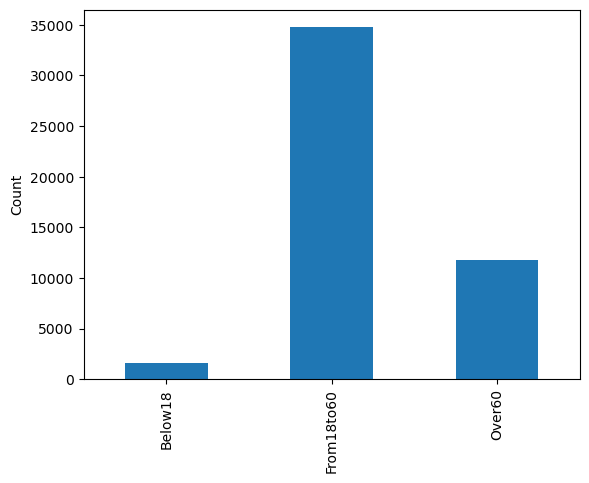

In [57]:
age_cat_order = ['Below18','From18to60','Over60']

print(df['age_cat'].value_counts())
df['age_cat'].value_counts().reindex(age_cat_order).plot.bar()
plt.ylabel('Count')
plt.savefig('../figures/age_category_barchart.png')
plt.show()

count    48153.000000
mean        48.613399
std         14.707031
min          0.000000
25%         39.000000
50%         50.000000
75%         59.000000
max         97.000000
Name: age_at_list_registration, dtype: float64


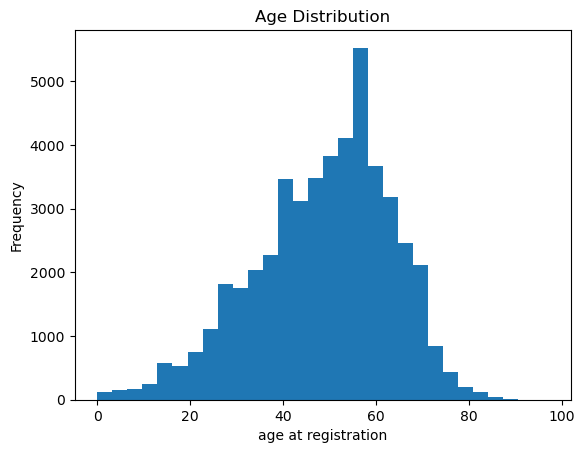

In [60]:
print(df['age_at_list_registration'].describe())
df['age_at_list_registration'].plot.hist(bins=30)
plt.xlabel('age at registration')
plt.title('Age Distribution')
plt.savefig('../figures/age_distribution.png')
plt.show()

Exploring the relationship between a person's age category and whether or not they receive a transplant:

In [18]:
# pd.value_counts(df['age_cat']).reindex(age_cat_order).plot.bar()
# df.plot.bar(x=df['age_cat'], y=df['Time_Tx'])
count_matrix = df.groupby(['age_cat', 'Transplant_Y_N']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)

Transplant_Y_N      N      Y
age_cat                     
Below18           524   1102
From18to60      24241  10511
Over60           9656   2119
Transplant_Y_N         N         Y
age_cat                           
Below18         0.322263  0.677737
From18to60      0.697543  0.302457
Over60          0.820042  0.179958


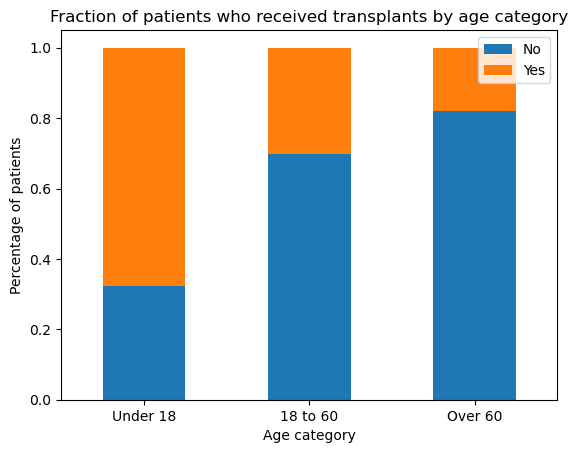

In [56]:
count_matrix_norm.plot.bar(stacked=True)
plt.xticks(ticks=np.arange(3),
           labels=['Under 18','18 to 60','Over 60'],
           rotation=0)
plt.xlabel('Age category')
plt.ylabel('Percentage of patients')
plt.title('Fraction of patients who received transplants by age category')
plt.legend(labels=['No', 'Yes'])
plt.savefig('../figures/transplant_y_n_by_age_cat.png')
plt.show()

Now looking at the sex feature.

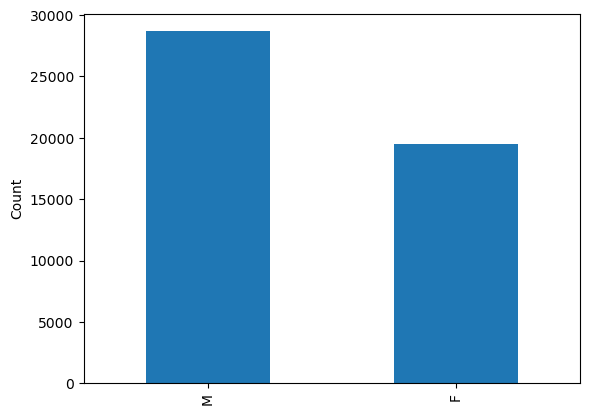

Percentage of patients by sex:
M    0.595685
F    0.404315
Name: sex, dtype: float64


In [20]:
df['sex'].value_counts().plot.bar()
plt.ylabel('Count')
plt.savefig('../figures/sex_barchart.png')
plt.show()
print('Percentage of patients by sex:')
print(df['sex'].value_counts()/len(df))

Now looking at time_on_Dialysis

count    46817.000000
mean        21.054254
std         29.212685
min          0.000000
25%          5.000000
50%         10.000000
75%         23.000000
max        180.000000
Name: time_on_Dialysis, dtype: float64
Number of missing values in the time on dialysis feature:
1336


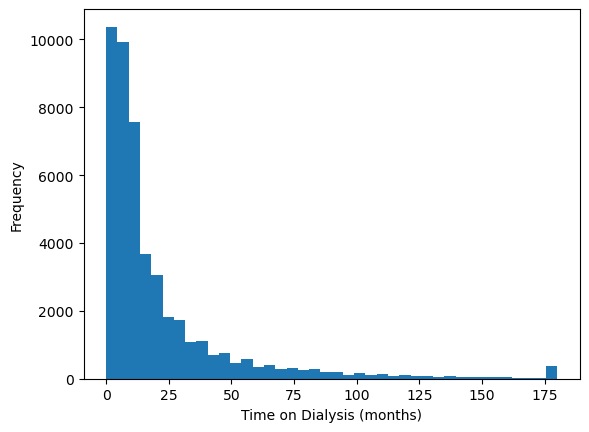

In [21]:
print(df['time_on_Dialysis'].describe())
na = df['time_on_Dialysis'].isnull()
print('Number of missing values in the time on dialysis feature:')
print(na.sum())
df['time_on_Dialysis'].plot.hist(bins=40)
plt.xlabel('Time on Dialysis (months)')
plt.savefig('../figures/time_on_dialysis_histogram.png')
plt.show()

The race feature.

Branca     32455
Parda       9032
Negra       5718
Amarela      948
Name: race, dtype: int64


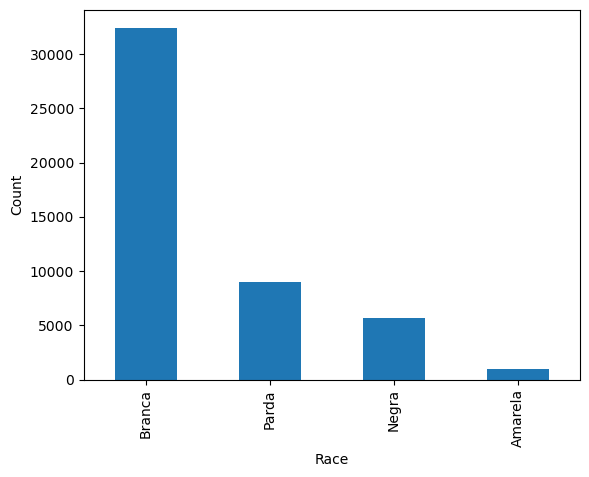

In [22]:
print(df['race'].value_counts())

df['race'].value_counts().plot.bar()
plt.xlabel('Race')
plt.ylabel('Count')
plt.savefig('../figures/race_barplot.png')
plt.show()

Underlying disease feature.

Other                                 16626
Hemolytic uremic syndrome (HUS)       13165
Diabetes                               9987
Glumerulo-Nephrotic Syndrome (GNS)     7234
Pylonephritis (PN)                     1141
Name: underlying_disease, dtype: int64


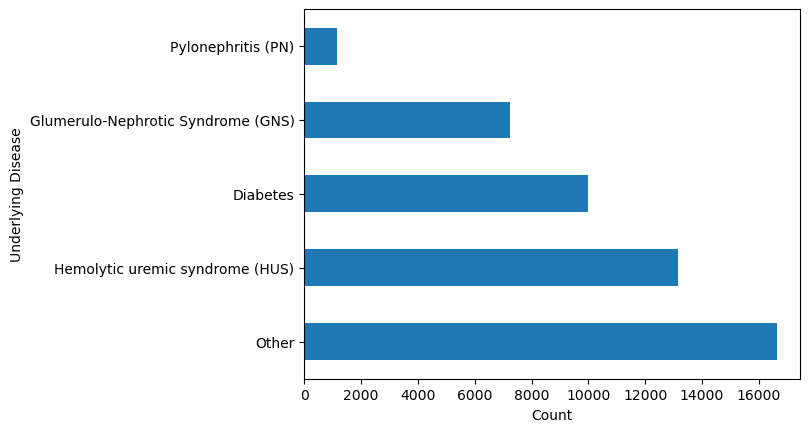

In [23]:
print(df['underlying_disease'].value_counts())

df['underlying_disease'].value_counts().plot.barh()
plt.ylabel('Underlying Disease')
plt.xlabel('Count')
plt.savefig('../figures/underlying_disease_barplot.png')
plt.show()

Diabetes feature.

In [24]:
print(df['diabetes'].value_counts())
print('38166 patients do NOT have diabetes.\n\
9987 patients have diabetes.')

1    38166
0     9987
Name: diabetes, dtype: int64
38166 patients do NOT have diabetes.
9987 patients have diabetes.


Blood type feature.

O     23640
A     16951
B      5834
AB     1728
Name: Blood_type, dtype: int64


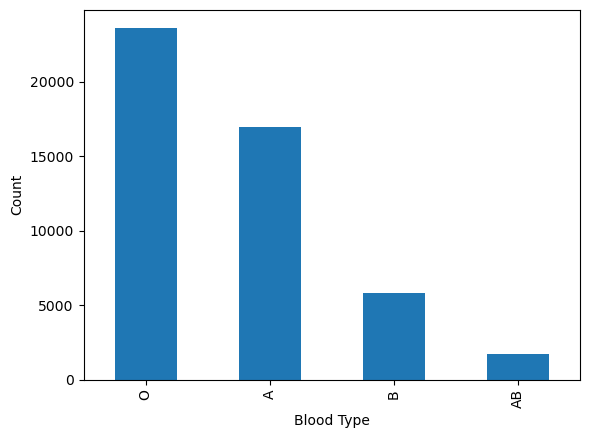

In [25]:
print(df['Blood_type'].value_counts())

df['Blood_type'].value_counts().plot.bar()
plt.xlabel('Blood Type')
plt.ylabel('Count')
plt.savefig('../figures/Blood_type_barplot.png')
plt.show()

Number of transfusions feature.

In [26]:
print(df['number_transfusion'].value_counts())

0    31398
1    14427
2     1547
3      781
Name: number_transfusion, dtype: int64


Gestation feature.

N    36122
Y    12031
Name: gestation, dtype: int64
N    0.750151
Y    0.249849
Name: gestation, dtype: float64


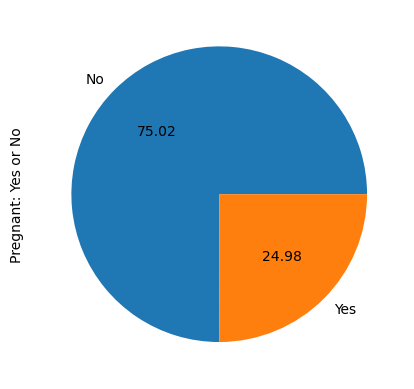

In [27]:
print(df['gestation'].value_counts())

percent_pregnant = df['gestation'].value_counts()/len(df)
print(percent_pregnant)
percent_pregnant.plot.pie(labels=['No','Yes'],autopct='%.2f')
plt.ylabel('Pregnant: Yes or No')
plt.savefig('../figures/pie_gestation.png')
plt.show()

number_gestation

In [28]:
print(df['number_gestation'].value_counts())
na_num_gest = df['number_gestation'].isnull()
print('Number of missing values in the number_gestation feature:')
print(na_num_gest.sum())

0.0     7433
2.0     3057
3.0     2891
1.0     2044
4.0     1606
5.0      942
6.0      543
7.0      319
8.0      222
10.0     143
9.0      113
11.0      49
12.0      32
13.0      26
14.0      19
17.0       6
15.0       5
16.0       5
18.0       3
63.0       1
35.0       1
41.0       1
22.0       1
20.0       1
24.0       1
Name: number_gestation, dtype: int64
Number of missing values in the number_gestation feature:
28689


prior_transplant

N    41983
Y     6170
Name: prior_transplant, dtype: int64
N    0.871867
Y    0.128133
Name: prior_transplant, dtype: float64


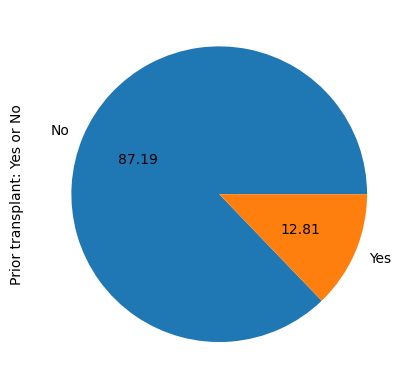

In [29]:
print(df['prior_transplant'].value_counts())

percent_prior_tx = df['prior_transplant'].value_counts()/len(df)
print(percent_prior_tx)
percent_prior_tx.plot.pie(labels=['No','Yes'],autopct='%.2f')
plt.ylabel('Prior transplant: Yes or No')
plt.savefig('../figures/pie_prior_transplant.png')
plt.show()

Number of prior transplants

In [30]:
print(df['number_prior_transplant'].value_counts())

0    41983
1     5428
2      630
3       94
4       14
5        4
Name: number_prior_transplant, dtype: int64


subregion

In [31]:
print(df['subregion'].value_counts())

UNIFESP    23166
HCFMUSP    13792
FUNDERP     7791
UNICAMP     3404
Name: subregion, dtype: int64


cPRA and cPRA_cat

count    48153.000000
mean        14.402093
std         29.119877
min          0.000000
25%          0.000000
50%          0.000000
75%          9.000000
max        100.000000
Name: cPRA, dtype: float64
Zero          34205
ZeroTo50       7311
Over80         3895
From50To80     2742
Name: cPRA_cat, dtype: int64


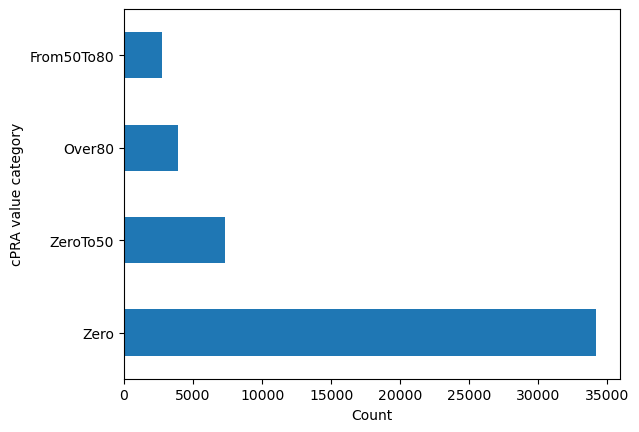

In [32]:
print(df['cPRA'].describe())
print(df['cPRA_cat'].value_counts())

df['cPRA_cat'].value_counts().plot.barh()
plt.xlabel('Count')
plt.ylabel('cPRA value category')
plt.savefig('../figures/cPRA_cat_barplot.png')
plt.show()

HLA_A1, HLA_A2, HLA_B1, HLA_B2, HLA_DR1, HLA_DR2

In [33]:
hla_feature = ['HLA_A1', 'HLA_A2', 'HLA_B1', 'HLA_B2', 'HLA_DR1', 'HLA_DR2']
for f in hla_feature:
    print(df[f].describe())

count    48153.000000
mean        10.359168
std         13.485239
min          0.000000
25%          2.000000
50%          2.000000
75%         23.000000
max         80.000000
Name: HLA_A1, dtype: float64
count    48153.000000
mean        28.816211
std         21.826129
min          0.000000
25%         11.000000
50%         29.000000
75%         33.000000
max         80.000000
Name: HLA_A2, dtype: float64
count    48153.000000
mean        25.750836
std         15.865324
min          0.000000
25%         14.000000
50%         18.000000
75%         40.000000
max         82.000000
Name: HLA_B1, dtype: float64
count    48153.000000
mean        41.148942
std         16.379271
min          0.000000
25%         35.000000
50%         44.000000
75%         51.000000
max         82.000000
Name: HLA_B2, dtype: float64
count    48153.000000
mean         5.986688
std          4.211553
min          0.000000
25%          3.000000
50%          4.000000
75%          9.000000
max         16.000000
Name

DR_00, B_00, A_00

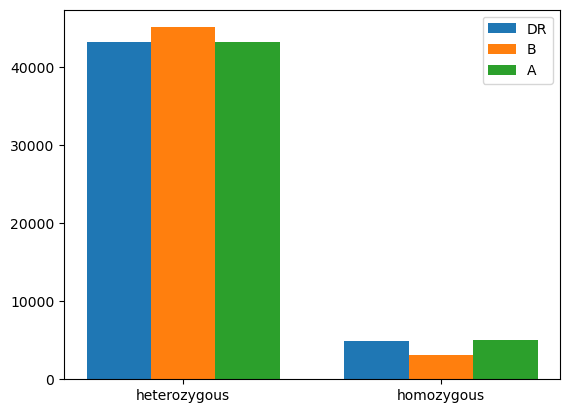

In [34]:
allele_feature = ['DR_00', 'B_00', 'A_00']

fig = plt.subplots()
barwidth = 0.25

bw1 = np.arange(2)
bw2 = [x + barwidth for x in bw1]
bw3 = [x + barwidth for x in bw2]

DR = df['DR_00'].value_counts()
B = df['B_00'].value_counts()
A = df['A_00'].value_counts()

plt.bar(bw1, DR, width=barwidth, label='DR')
plt.bar(bw2, B, width=barwidth, label='B')
plt.bar(bw3, A, width=barwidth, label='A')

plt.xticks([r + barwidth for r in range(2)], 
           ['heterozygous', 'homozygous'])

plt.legend()
plt.savefig('../figures/DR_B_A_allele_barplot.png')
plt.show()

calculated_frequency_DR.f1    
calculated_frequency_DR.f2    
calculated_frequency_DR.f     
calculated_frequency_B.f1     
calculated_frequency_B.f2     
calculated_frequency_B.f      
calculated_frequency_A.f1     
calculated_frequency_A.f2     
calculated_frequency_A.f      

In [35]:
calc_freq = ['calculated_frequency_DR.f1', 'calculated_frequency_DR.f2',
             'calculated_frequency_DR.f', 'calculated_frequency_B.f1',
             'calculated_frequency_B.f2', 'calculated_frequency_B.f', 
             'calculated_frequency_A.f1', 'calculated_frequency_A.f2',
             'calculated_frequency_A.f']
for f in calc_freq:
    print(df[f].value_counts())

0.23    13380
0.18     8157
0.19     7880
0.22     6413
0.12     3144
0.25     3122
0.04     1637
0.00     1267
0.21     1187
0.05     1026
0.07      940
Name: calculated_frequency_DR.f1, dtype: int64
0.23    9752
0.25    8832
0.21    7832
0.07    5912
0.22    3812
0.00    3721
0.12    2710
0.04    2178
0.18    1814
0.05    1131
0.19     459
Name: calculated_frequency_DR.f2, dtype: int64
0.00    4885
5.75    3143
5.06    2740
4.14    2610
4.83    2358
4.37    2176
5.29    1857
1.61    1841
2.76    1580
5.50    1487
4.50    1398
5.25    1183
3.96    1159
4.75    1117
4.18    1043
3.78    1002
4.62     996
0.92     922
3.42     920
1.75     881
0.84     869
3.99     864
3.00     805
1.54     736
1.26     715
1.47     673
2.64     645
2.52     636
1.33     634
2.16     614
1.15     536
2.28     516
1.00     506
0.72     411
0.88     390
1.25     307
0.28     306
0.76     286
0.48     262
0.90     250
1.10     244
0.95     197
1.05     197
6.25     170
0.49     168
0.35     140
3.24     13

chagas                         

In [36]:
print(df['chagas'].value_counts())

N    44069
Y       72
Name: chagas, dtype: int64


HBc_antibodies
HCV_antibodies
agHBs

In [37]:
print(df['HBc_antibodies'].value_counts())
print(df['HCV_antibodies'].value_counts())
print(df['agHBs'].value_counts())

N    47380
Y      773
Name: HBc_antibodies, dtype: int64
N    43595
Y      546
Name: HCV_antibodies, dtype: int64
N    44022
Y      119
Name: agHBs, dtype: int64


patient_still_on_list

In [38]:
print(df['patient_still_on_list'].value_counts())

N    37250
Y    10903
Name: patient_still_on_list, dtype: int64


death

N    36592
Y    11561
Name: death, dtype: int64
N    0.759911
Y    0.240089
Name: death, dtype: float64


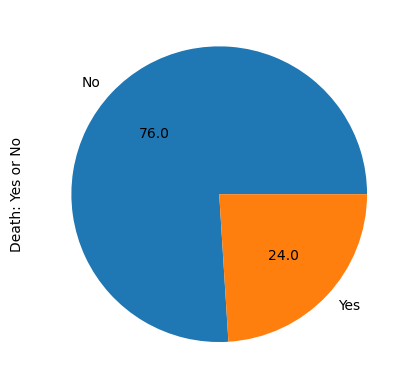

In [39]:
print(df['death'].value_counts())
percent_death = df['death'].value_counts()/len(df)
print(percent_death)
percent_death.plot.pie(labels=['No','Yes'],autopct='%.1f')
plt.ylabel('Death: Yes or No')
plt.savefig('../figures/pie_death.png')
plt.show()

Time_death

count    48153.000000
mean        75.726372
std         57.602143
min          0.000000
25%         27.000000
50%         61.000000
75%        112.000000
max        226.000000
Name: Time_death, dtype: float64


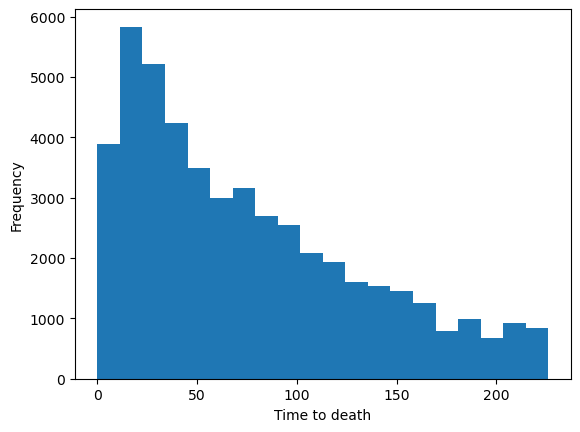

In [40]:
print(df['Time_death'].describe())
df['Time_death'].plot.hist(bins=20)
plt.xlabel('Time to death')
plt.savefig('../figures/time_death_histogram.png')
plt.show()

removed_list

In [41]:
print(df['removed_list'].value_counts())

N    32858
Y    15295
Name: removed_list, dtype: int64


razon_removed

In [42]:
print(df['razon_removed'].value_counts())
print(df['razon_removed'].value_counts().sum())

Removido (suspenso > 365 dias)     12985
Transferido para outro Estado        662
Não quer ser transplantado           592
Removido sem condições clínicas      412
Removido pela equipe                 254
Função renal recuperada              212
Abandonou o tratamento                93
Removido administrativo               62
Removido (inscrição duplicada)        17
Transferido de Equipe                  6
Name: razon_removed, dtype: int64
15295


event

In [43]:
print(df['event'].value_counts())
# determining what the events mean - comparing event to deaths
print(df[df['event']==0]['death'].value_counts())
print(df[df['event']==1]['death'].value_counts())
print(df[df['event']==2]['death'].value_counts())
print(df[df['event']==3]['death'].value_counts())
# num_deaths = 11561
# count = 9132 + 2429
# print(count)

3    14356
1    13732
0    10933
2     9132
Name: event, dtype: int64
N    10933
Name: death, dtype: int64
N    11303
Y     2429
Name: death, dtype: int64
Y    9132
Name: death, dtype: int64
N    14356
Name: death, dtype: int64


In [44]:
# comparing event to Transplant_Y_N
print(df[df['event']==0]['Transplant_Y_N'].value_counts())
print(df[df['event']==1]['Transplant_Y_N'].value_counts())
print(df[df['event']==2]['Transplant_Y_N'].value_counts())
print(df[df['event']==3]['Transplant_Y_N'].value_counts())

N    10933
Name: Transplant_Y_N, dtype: int64
Y    13732
Name: Transplant_Y_N, dtype: int64
N    9132
Name: Transplant_Y_N, dtype: int64
N    14356
Name: Transplant_Y_N, dtype: int64


Based on this information, we can infer the following:
- When event = 0 or event = 3, the patient did not receive a transplant and they did not die
- When event = 1, the patient received a transplant and they may have lived or died
- When event = 2, the patient did not receive a transplant and they died

Comparing cPRA to Transplant_Y_N with a violin plot

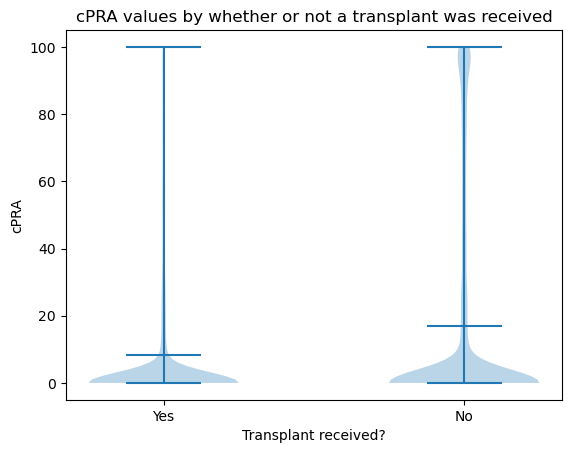

In [45]:
dataset = [df[df['Transplant_Y_N']=='Y']['cPRA'].values,
           df[df['Transplant_Y_N']=='N']['cPRA'].values]

plt.violinplot(dataset = dataset, showmeans=True)
plt.xticks([1,2],['Yes','No'])
plt.ylabel('cPRA')
plt.xlabel('Transplant received?')
plt.title('cPRA values by whether or not a transplant was received')
plt.savefig('../figures/violin_transplant_by_cPRA.png')
plt.show()

Comparing cPRA values to sex with a violin plot.

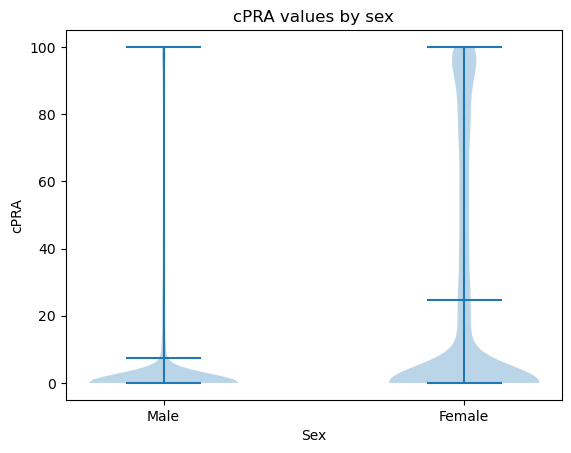

In [46]:
dataset = [df[df['sex']=='M']['cPRA'].values,
           df[df['sex']=='F']['cPRA'].values]

plt.violinplot(dataset = dataset, showmeans=True)
plt.xticks([1,2],['Male','Female'])
plt.ylabel('cPRA')
plt.xlabel('Sex')
plt.title('cPRA values by sex')
plt.savefig('../figures/violin_sex_by_cPRA.png')
plt.show()

In [47]:
sex_count_matrix = df.groupby(['sex', 'Transplant_Y_N']).size().unstack()
print(sex_count_matrix)
sex_count_matrix_norm = sex_count_matrix.div(sex_count_matrix.sum(axis=1),axis=0)
print(sex_count_matrix_norm)

Transplant_Y_N      N     Y
sex                        
F               14204  5265
M               20217  8467
Transplant_Y_N         N         Y
sex                               
F               0.729570  0.270430
M               0.704818  0.295182


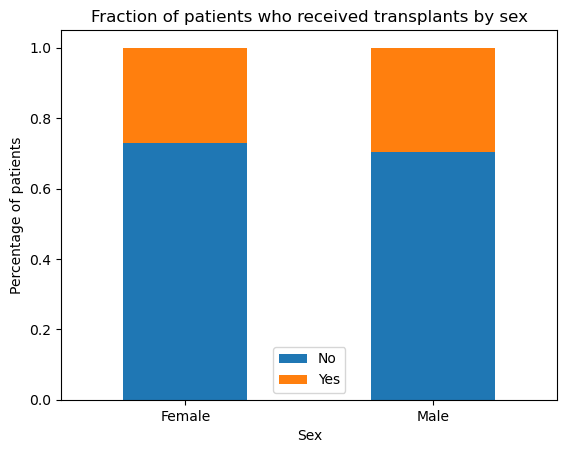

In [48]:
sex_count_matrix_norm.plot.bar(stacked=True)
plt.xticks(ticks=np.arange(2),
           labels=['Female','Male'],
           rotation=0)
plt.xlabel('Sex')
plt.ylabel('Percentage of patients')
plt.title('Fraction of patients who received transplants by sex')
plt.legend(labels=['No', 'Yes'])
plt.savefig('../figures/transplant_y_n_by_sex.png')
plt.show()

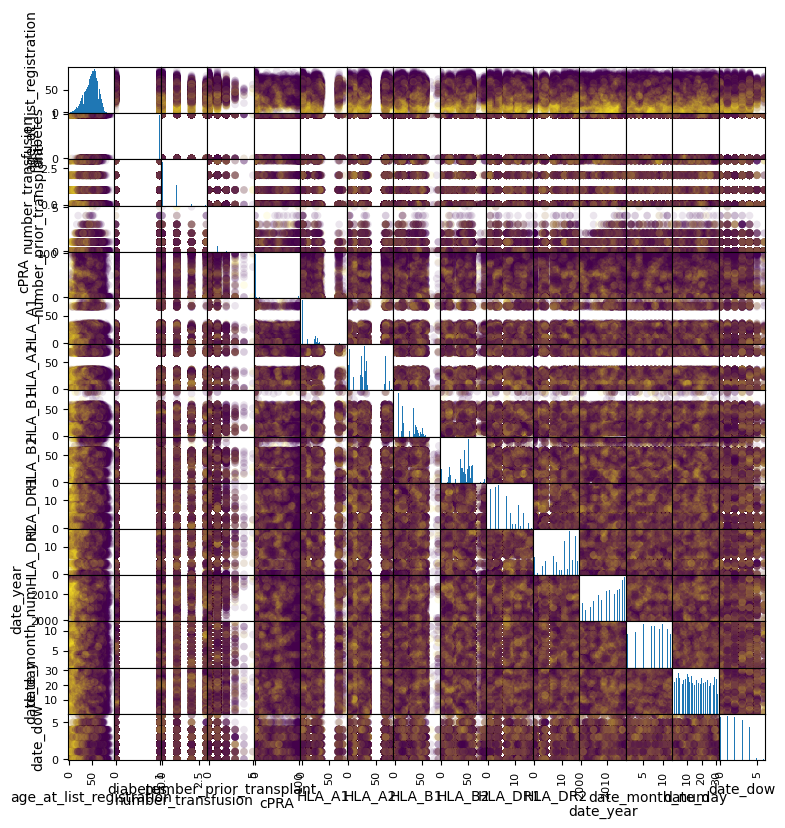

In [108]:
pd.plotting.scatter_matrix(df.select_dtypes(int), figsize=(9, 9),c = pd.get_dummies(df['Transplant_Y_N']).iloc[:,1], 
                           marker='o',hist_kwds={'bins': 50}, s=30, alpha=.1)
plt.show()

<AxesSubplot:xlabel='age_at_list_registration', ylabel='HLA_DR1'>

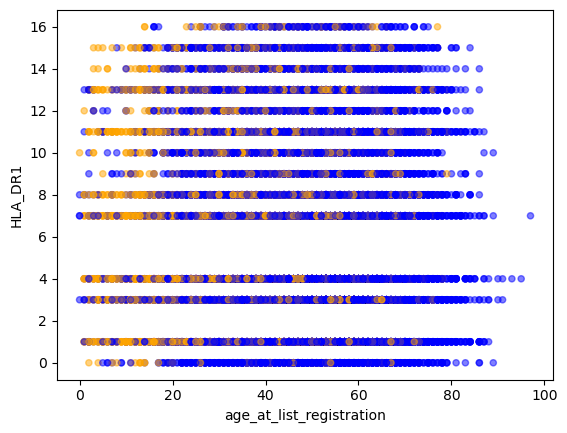

In [49]:
colors = {'Y':'orange','N':'blue'}

df.plot.scatter('age_at_list_registration', 'HLA_DR1', 
                c=df['Transplant_Y_N'].map(colors),
                alpha=0.5)

HEATMAP!

In [50]:
# nbins = 40

# heatmap, xedges, yedges = np.histogram2d(df['HLA_DR1'], 
#                                          df['cPRA'], bins=nbins)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.imshow(np.log10(heatmap).T, origin='lower',vmin=0) # use log count


### Data Preprocessing
The dataset is IID and it does not have group structure. Each patient on the waitlist only occupies one row of the dataset. This is not time-series data.

- How do you split the dataset given your ML question to best mimic future use when you deploy the model?

Before preprocessing, we must drop any features which we will not have for a new patient added to the waitlist. The goal of this ML model is to be able to predict whether a new patient added to this kidney transplant waitlist will receive a transplant or not at some point. In order to train the model properly for real-life use, we must only consider features of the dataset that will be available for any new patient on the day that they are added to the list. Any features that do not fit this condition will be dropped.

In [51]:
# list of features to drop because they won't exist for a new patient
to_drop = ['patient_still_on_list','death','Time_death','Time_Tx',
           'removed_list','razon_removed','time','event',
           'calculated_frequency_DR.f1','calculated_frequency_DR.f2',
           'calculated_frequency_DR.f','calculated_frequency_B.f1',
           'calculated_frequency_B.f2','calculated_frequency_B.f',
           'calculated_frequency_A.f1','calculated_frequency_A.f2',
           'calculated_frequency_A.f']
df.drop(columns=to_drop,inplace=True)

In [52]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold

# separating feature matrix X from target variable y
y = df['Transplant_Y_N']
X = df.loc[:, df.columns != 'Transplant_Y_N']
print(y.head())
print(X.head())

random_state = 42

# train-test-split to isolate training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size=0.8,random_state=random_state)

# train-test-split to separate training and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state = random_state)

print('training set:',X_train.shape,y_train.shape) # 80% of points are in training
print('validation set:',X_val.shape,y_val.shape) # 10% of points are in validation
print('test set:',X_test.shape,y_test.shape) # 10% of points are in testing


# DELETE THIS STUFF
# X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.1,random_state=random_state)
# stratkf = StratifiedKFold(n_splits=3,shuffle=True,random_state=random_state)
# for train_index, val_index in stratkf.split(X_other,y_other):
#     print('new fold')
#     X_train = X_other.iloc[train_index]
#     y_train = y_other.iloc[train_index]
#     X_val = X_other.iloc[val_index]
#     y_val = y_other.iloc[val_index]
#     print(np.unique(y_train,return_counts=True))
#     print(np.unique(y_val,return_counts=True))

0    N
1    N
2    N
3    N
4    N
Name: Transplant_Y_N, dtype: object
   age_at_list_registration     age_cat  time_on_Dialysis    race sex  \
0                        67      Over60               1.0  Branca   M   
1                        58  From18to60               4.0  Branca   M   
2                        51  From18to60               2.0  Branca   M   
3                        52  From18to60              17.0  Branca   M   
4                        67      Over60              68.0   Parda   M   

                underlying_disease  diabetes Blood_type  number_transfusion  \
0                            Other         1          A                   0   
1                         Diabetes         0          A                   0   
2  Hemolytic uremic syndrome (HUS)         1          O                   0   
3                         Diabetes         0          O                   0   
4  Hemolytic uremic syndrome (HUS)         1          A                   0   

  gestation  ..

- Apply MinMaxEncoder or StandardScaler on the continuous features
- Apply OneHotEncoder or OrdinalEncoder on categorical and ordinal features

In [53]:
print(X.dtypes)
# making lists to contain the continuous, ordinal, and categorical features
continuous_features = ['age_at_list_registration','time_on_Dialysis',
                       'number_transfusion','number_gestation','cPRA',
                       'HLA_A1','HLA_A2','HLA_B1','HLA_B2','HLA_DR1',
                       'HLA_DR2','number_prior_transplant','date_year',
                       'date_month_num','date_day','date_dow']

ordinal_features = ['age_cat','cPRA_cat']
ordinal_cats = [['Below18','From18to60','Over60'],
                ['Zero','ZeroTo50','From50To80','Over80']]

categorical_features = ['race','sex','underlying_disease','diabetes','Blood_type',
                        'gestation','prior_transplant','subregion','DR_00',
                        'B_00','A_00','chagas','HBc_antibodies','HCV_antibodies',
                        'agHBs']

# checking to ensure the feature lists are the same length as the feature matrix
num_features_in_lists = len(continuous_features) + len(ordinal_features) + len(categorical_features)
print('Number of continuous features:',len(continuous_features))
print('Number of ordinal features:',len(ordinal_features))
print('Number of categorical features:',len(categorical_features))
print('Number of features in lists:',num_features_in_lists)
print('Number of features in X:',X.shape[1])

age_at_list_registration      int64
age_cat                      object
time_on_Dialysis            float64
race                         object
sex                          object
underlying_disease           object
diabetes                      int64
Blood_type                   object
number_transfusion            int64
gestation                    object
number_gestation            float64
prior_transplant             object
number_prior_transplant       int64
subregion                    object
cPRA                          int64
cPRA_cat                     object
HLA_A1                        int64
HLA_A2                        int64
HLA_B1                        int64
HLA_B2                        int64
HLA_DR1                       int64
HLA_DR2                       int64
DR_00                        object
B_00                         object
A_00                         object
chagas                       object
HBc_antibodies               object
HCV_antibodies              

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import RandomForestRegressor

random_state = 42

# one-hot encoder
# We need to replace the NaN with a string
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, continuous_features),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_features)])

In [55]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# the feature names after fit
ftr_names = preprocessor.get_feature_names_out()

# converting the numpy array back to a data frame
df_train_preprocessed = pd.DataFrame(data=X_prep,columns=ftr_names)
print(df_train_preprocessed.shape)

# transforming the validation set
X_val_prep = preprocessor.transform(X_val)
df_val_preprocessed = pd.DataFrame(data=X_val_prep,columns = ftr_names)
print(df_val_preprocessed.shape)

# transforming the test set
X_test_prep = preprocessor.transform(X_test)
df_test_preprocessed = pd.DataFrame(data=X_test_prep,columns = ftr_names)
print(df_test_preprocessed.shape)
print(ftr_names)

(38522, 60)
(4815, 60)
(4816, 60)
['num__age_at_list_registration' 'num__time_on_Dialysis'
 'num__number_transfusion' 'num__number_gestation' 'num__cPRA'
 'num__HLA_A1' 'num__HLA_A2' 'num__HLA_B1' 'num__HLA_B2' 'num__HLA_DR1'
 'num__HLA_DR2' 'num__number_prior_transplant' 'num__date_year'
 'num__date_month_num' 'num__date_day' 'num__date_dow' 'cat__race_Amarela'
 'cat__race_Branca' 'cat__race_Negra' 'cat__race_Parda' 'cat__sex_F'
 'cat__sex_M' 'cat__underlying_disease_Diabetes'
 'cat__underlying_disease_Glumerulo-Nephrotic Syndrome (GNS)'
 'cat__underlying_disease_Hemolytic uremic syndrome (HUS)'
 'cat__underlying_disease_Other'
 'cat__underlying_disease_Pylonephritis (PN)' 'cat__diabetes_0'
 'cat__diabetes_1' 'cat__Blood_type_A' 'cat__Blood_type_AB'
 'cat__Blood_type_B' 'cat__Blood_type_O' 'cat__gestation_N'
 'cat__gestation_Y' 'cat__prior_transplant_N' 'cat__prior_transplant_Y'
 'cat__subregion_FUNDERP' 'cat__subregion_HCFMUSP'
 'cat__subregion_UNICAMP' 'cat__subregion_UNIFESP'
 'cat

- How many features do you have in the preprocessed data?

There are 60 features in the preprocessed data.